### NGUEKENG TIEUMENA MARC DONALD - ENSPY 

**IMPORT NECESSARY LIBRARIES**

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

**IMPORT DATASET**

In [3]:
imdb=pd.read_csv('IMDB Dataset.csv')

In [5]:
# build train and test datasets
reviews = imdb['review'].values
sentiments = imdb['sentiment'].values

train_reviews = reviews[:35000]
train_sentiments = sentiments[:35000]

test_reviews = reviews[35000:]
test_sentiments = sentiments[35000:]

# **FIRST APPROACH**

## CONVOLUTIONAL NEURAL NETWORK

**PREPROCESSING**

Preprocessing is an important step in NLP tasks. It transforms text into a more digestible form so that machine learning algorithms can perform better.

In [6]:
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata


def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()  
    norm_docs.append(doc)
  
  return norm_docs

**Text normalization and Tokenization**

Tokenization is about splitting strings of text into smaller pieces, or “tokens”. Paragraphs can be tokenized into sentences and sentences can be tokenized into words.

In [7]:
%%time

norm_train_reviews = pre_process_corpus(train_reviews)
norm_test_reviews = pre_process_corpus(test_reviews)

100%|██████████| 15000/15000 [00:05<00:00, 2824.16it/s]

Wall time: 17.8 s


In [8]:
t = Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(norm_train_reviews)
t.word_index['<PAD>'] = 0

In [9]:
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('dawgis', 175795), ('<PAD>', 0), 1)

In [10]:
train_sequences = t.texts_to_sequences(norm_train_reviews)
test_sequences = t.texts_to_sequences(norm_test_reviews)

In [11]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=175796
Number of Documents=35000


Plot the distribution of sequences of our data

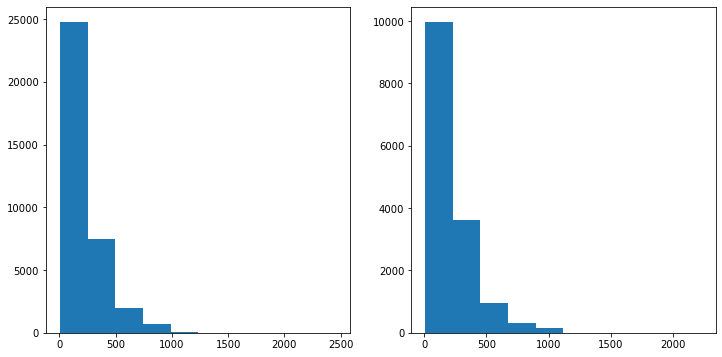

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]
test_lens = [len(s) for s in test_sequences]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

In [13]:
MAX_SEQUENCE_LENGTH = 1000

In [14]:
# pad dataset to a maximum review length in words
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((35000, 1000), (15000, 1000))

### Encoding of classes in two classes

In [15]:
le = LabelEncoder()
num_classes=2 # positive -> 1, negative -> 0

In [16]:
y_train = le.fit_transform(train_sentiments)
y_test = le.transform(test_sentiments)

In [17]:
VOCAB_SIZE = len(t.word_index)
VOCAB_SIZE

175796

In [18]:
EMBED_SIZE = 300
EPOCHS=2
BATCH_SIZE=128

In [27]:
# create the model
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1000, 300)         52738800  
                                                                 
 conv1d (Conv1D)             (None, 1000, 128)         153728    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 500, 128)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 500, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 250, 64)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 250, 32)          

In [28]:
# Fit the model
history= model.fit(X_train, y_train, 
          validation_split=0.2,
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          verbose=1)

Epoch 1/2
219/219 [==============================] - 166s 757ms/step - loss: 0.4281 - accuracy: 0.7580 - val_loss: 0.2480 - val_accuracy: 0.9006
Epoch 2/2
219/219 [==============================] - 165s 754ms/step - loss: 0.1327 - accuracy: 0.9532 - val_loss: 0.2490 - val_accuracy: 0.9077


In [29]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

469/469 [==============================] - 14s 30ms/step - loss: 0.2468 - accuracy: 0.9038
Accuracy: 90.38%


In [30]:
# show the predict classes on 10 item
predictions = (model.predict(X_test) > 0.5).astype("int32").ravel()
predictions[:10]

array([0, 1, 0, 1, 1, 0, 1, 0, 1, 1])

In [31]:
#show the predictions of 10 items
predictions = ['positive' if item == 1 else 'negative' for item in predictions]
predictions[:10]

['negative',
 'positive',
 'negative',
 'positive',
 'positive',
 'negative',
 'positive',
 'negative',
 'positive',
 'positive']

### Our model predict well on these items

In [32]:
from sklearn.metrics import confusion_matrix, classification_report

labels = ['negative', 'positive']
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

    negative       0.91      0.90      0.90      7490
    positive       0.90      0.91      0.90      7510

    accuracy                           0.90     15000
   macro avg       0.90      0.90      0.90     15000
weighted avg       0.90      0.90      0.90     15000



,negative,positive
negative,6756,734
positive,709,6801


Let us plot the loss and the accuracy

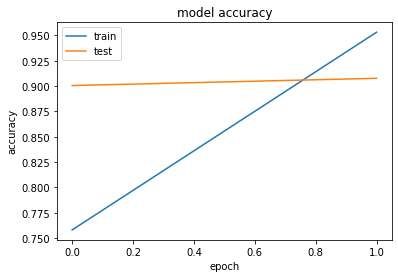

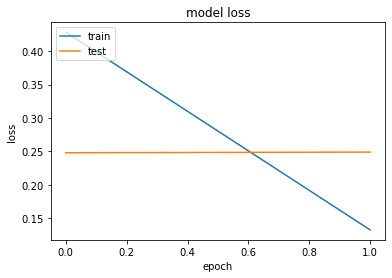

In [33]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# **SECOND APPROACH**

## LSTM APPROACH

Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies.

They work tremendously well on a large variety of problems, and are now widely used.

LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn.

In [57]:
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup

import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from textblob import TextBlob
from textblob import Word

In [58]:
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [WinError 10054]
[nltk_data]     An existing connection was forcibly closed by the
[nltk_data]     remote host>


False

Text normalization

In [59]:
#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

Removing html strips and noise text

In [62]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
#Apply function on review column
imdb['review']=imdb['review'].apply(denoise_text)

#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
#Apply function on review column
imdb['review']=imdb['review'].apply(remove_special_characters)

#Stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text
#Apply function on review column
imdb['review']=imdb['review'].apply(simple_stemmer)

In [63]:
#set stopwords to english
stop=set(stopwords.words('english'))
print(stop)


{'any', "won't", 't', 'he', 'from', 'not', 'no', 'by', 'so', 'this', 'she', 'does', 'until', 'at', "you've", 'themselves', "shan't", 'which', 'own', 'again', 'didn', 'once', 'as', 'such', 'm', 'haven', 'has', 'but', 'off', 'ours', 'few', 'before', 'too', 'that', 'being', "haven't", 'or', 'they', 'hasn', 'its', "weren't", 'is', 'myself', 'between', "couldn't", 'having', 'in', 'each', 'the', 'll', 'over', 'our', 'itself', 'and', 'shouldn', 'after', "don't", "she's", 'who', 'do', 'them', "hasn't", 'me', "isn't", 'needn', 'yours', 'her', 'mightn', 'you', 'of', 'it', 'won', 'should', 'these', 'are', 'y', 'because', "aren't", "needn't", 'some', 'both', 'i', "wasn't", 'am', 'whom', 'through', 'theirs', 'be', 'what', 'was', 'did', 'where', 'up', 'himself', 'my', 'about', 'if', "you're", 'doesn', 'were', "mustn't", 'your', 'to', 'while', 'can', 'below', 'how', 'couldn', 'further', 'when', 'very', 'shan', 'there', 're', 'aren', 'had', 'doing', 'now', "that'll", 'other', 'out', 'his', 'most', 'do

In [64]:

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
#Apply function on review column
imdb['review']=imdb['review'].apply(remove_stopwords)

In [65]:
from sklearn.model_selection import train_test_split

In [69]:
X=imdb['review'].to_numpy()
y=imdb['sentiment'].to_numpy()

In [68]:
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [42]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=1)

In [19]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

We will use l2 regularization to fix the overfitting problems

In [20]:
from keras.regularizers import l2

In [43]:
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer

We convert the sentences into word-to-index dictionary.
The tokenizer class of keras.preprocessing.text allows us to choose which words will be represented. So only those with particular frequencies will be used as dimensions of our vector space. 

In [70]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(xtrain)

Xtrain = tokenizer.texts_to_sequences(xtrain)
Xtest = tokenizer.texts_to_sequences(xtest)

This operation constitutes the words embedding


The operation below give us vectors with different size.
We have to make them the same size

The following script finds the vocabulary size and then perform padding on both train and test set.

In [71]:
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

Xtrain = pad_sequences(Xtrain, padding='post', maxlen=maxlen)
Xtest = pad_sequences(Xtest, padding='post', maxlen=maxlen)

In [72]:
len(tokenizer.word_index)

112619

We use adam optimization for the learning rate

We also use dropout regularization

In [73]:
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=maxlen ))
model.add(LSTM(128, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01), dropout=0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

We split the set to have the validation set, which hepls us to choose the best hyperparameters

In [74]:
import  tensorflow as tf

In [75]:
history = model.fit(Xtrain, ytrain, batch_size=128, epochs=4, verbose=1, validation_split=0.2)

Epoch 1/4
250/250 [==============================] - 45s 177ms/step - loss: 1.8822 - acc: 0.7187 - val_loss: 1.1500 - val_acc: 0.8430
Epoch 2/4
250/250 [==============================] - 43s 172ms/step - loss: 0.9393 - acc: 0.8655 - val_loss: 0.8009 - val_acc: 0.8476
Epoch 3/4
192/250 [======================>.......] - ETA: 9s - loss: 0.6731 - acc: 0.8818

Let us plot the loss and the accuracy

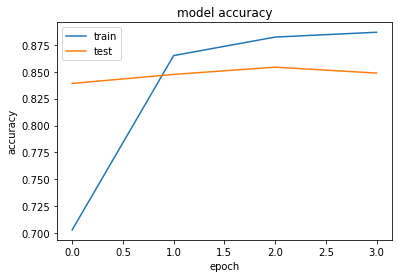

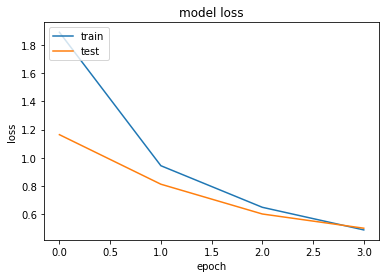

In [51]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [53]:
Xtest = tokenizer.texts_to_sequences(xtest)
Xtest = pad_sequences(Xtest, padding='post', maxlen=maxlen)

**Evaluation on test set**

In [54]:
score = model.evaluate(Xtest, ytest, verbose=1)

313/313 [==============================] - 5s 14ms/step - loss: 0.4813 - acc: 0.8625


# **FINAL APPROACH**

# **BIDIRECTIONAL ENCODER REPRESENTATION FROM TRANSFORMERS (BERT) APPROACH**

## Pre-trained model BERT with ktrain

In [ ]:
#split the dataset  
#train datasetta
train=imdb[:40000]

#test dataset
test=imdb[40000:]
print(train.shape,test.shape)


In [ ]:
!pip install ktrain

In [ ]:
#important librairies for bert training
import ktrain
from ktrain import text


In [ ]:
#Split train and test data with bert 
(X_train,y_train),(X_test,y_test),preprocess=text.texts_from_df(train_df=train,
 text_column='review',
 label_columns='sentiment',
 val_df=test,
 maxlen=400,
 preprocess_mode='bert')

In [ ]:
X_train[0].shape

In [ ]:
#here it is the model that will be trained and it prescribes us if it is a multi-label classsification or not and the maximum length of the sentences
model= text.text_classifier(name='bert',
                            train_data=(X_train,y_train),
                            preproc=preprocess)

Note that if a sentence is too long or longer than the defined maximum length it will be truncated and if it is too short its vector will be filled with zeros. All this to avoid having an unbalanced data set

In [ ]:
# get optimal learning rate(this might take days to run)
#learner.lr_find()
#learner.lr_plot()
#Optimal learning rate for this is 2e-5

In [ ]:
# Get Learning Rate
learner=ktrain.get_learner(model=model,
                           train_data=(X_train,y_train),
                           val_data=(X_test, y_test),
                           batch_size=6)

In [ ]:
# this fit take a lot of time so we train on 1 epochs to prevent also the over fit but we can compile it on 3 max epochs
history=learner.fit_onecycle(lr=2e-5, epochs=1)

The error above is not actually an error, our model has actually finished its calculations on all epochs; just that at the end there is a kind of infinite loop that does not stop the model so we stop it manually

In [ ]:
#compute the predictor 
predictor=ktrain.get_predictor(learner.model,preprocess)

In [ ]:
# run the predictor on new data 
predictor.predict(data)

In [ ]:
#save the model
predictor.save('/content/drive/MyDrive/Colab Notebooks/IMDB')